In [ ]:
import tensorflow as tf

In [ ]:
from keras.datasets.cifar10 import load_data

# load the images into memory
(X_train, y_train), (X_test, y_test) = load_data()

# Summarizing the train and test datasets
print("Train: ", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)

Using TensorFlow backend.


Train:  (50000, 32, 32, 3) (50000, 1)
Test:  (10000, 32, 32, 3) (10000, 1)


In [ ]:
import matplotlib.pyplot as plt

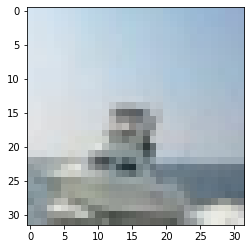

In [ ]:
plt.imshow(X_train[100])

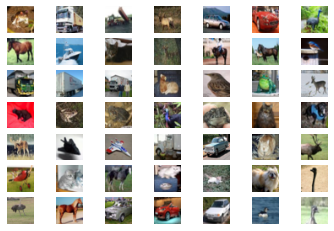

In [ ]:
for i in range(49):
  plt.subplot(7, 7, i+1)
  plt.axis('off')
  plt.imshow(X_train[i])
plt.show()

# Discriminator Model
#### Input: Image with a 3 color channel
#### Output: Binary Classification, likelihood of the sample being real or fake

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, LeakyReLU
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

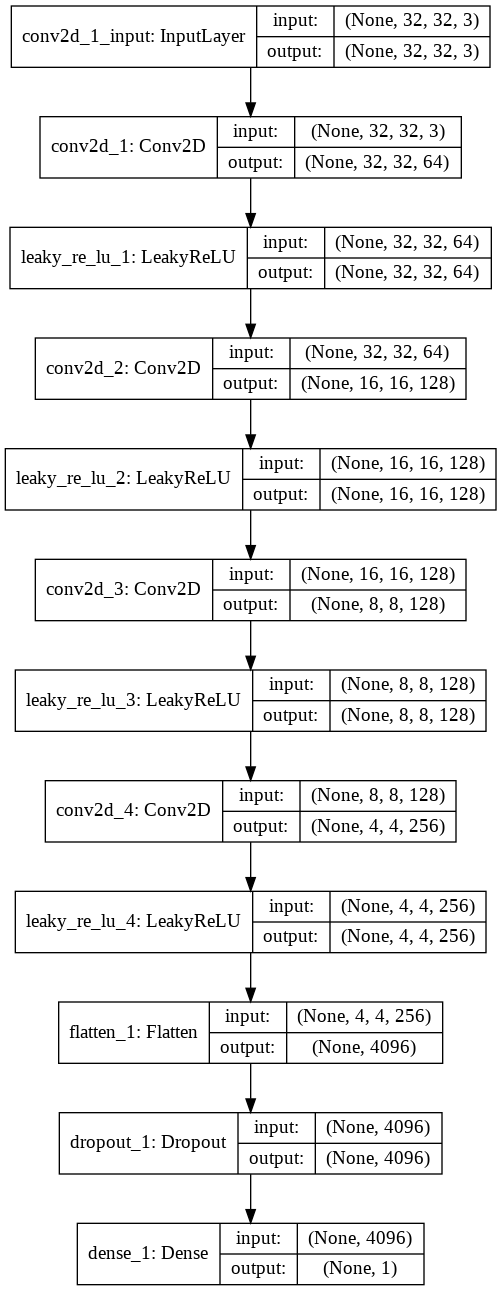

In [ ]:
def discriminator(in_shape=(32, 32, 3)):
  model = Sequential()

  # Normal Layer
  model.add(Conv2D(64, kernel_size=(3,3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha = 0.2))

  # Downsample layer
  model.add(Conv2D(128, (3,3), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha = 0.2))

  # Downsample Layer
  model.add(Conv2D(128, (3,3), padding='same', strides=(2,2)))
  model.add(LeakyReLU(alpha=0.2))

  # Downsample layer
  model.add(Conv2D(256, (3,3), padding='same', strides=(2,2)))
  model.add(LeakyReLU(0.2))

  # classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  # compile model
  model.compile(optimizer=Adam(lr=0.0002, beta_1=0.5),
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

d_model = discriminator()
# d_model.summary()
plot_model(d_model, show_shapes=True, show_layer_names=True)

In [ ]:
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint

In [ ]:
def load_real_samples():
  (X_train, _), (_, _) = load_data()

  X_train = X_train.astype('float32')

  X_train = (X_train-127.5)/127.5

  return X_train

In [ ]:
def generate_real_samples(dataset, n_samples):

  # choose random instances
  ix = randint(0, dataset.shape[0], n_samples)

  # retrieve selected images
  X = dataset[ix]

  # generate 'real' class labels 
  y = ones((n_samples, 1))

  return X, y

Generate n fake samples with class labels

In [ ]:
def generate_fake_samples(n_samples):

  # generate random uniform numbers in range [0,1]
  X = rand(32*32*3*n_samples)

  # update to have the range [-1,1]
  X = -1 + X*2

  # reshape into a batch of color images
  X = X.reshape(n_samples, 32, 32, 3)

  # generate fake class labels [0]
  y = zeros((n_samples, 1))

  return X, y


Train the discriminator model

In [ ]:
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
  half_batch = n_batch//2

  # manually enumerate epochs
  for i in range(n_iter):
    # get randomly selected 'real' samples
    X_real, y_real = generate_real_samples(dataset, half_batch)

    # update discriminator on real samples
    _, real_acc = model.train_on_batch(X_real, y_real)

    # generate fake samples
    X_fake, y_fake = generate_fake_samples(half_batch)

    # Update discriminator on fake samples
    _, fake_acc = model.train_on_batch(X_fake, y_fake)

    # Summarize performance
    print(f"{i+1} Real : {real_acc*100}  Fake : {fake_acc*100}")


In [ ]:
# define the discriminator model
model = discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

1 Real : 15.625  Fake : 9.375
2 Real : 92.1875  Fake : 29.6875
3 Real : 90.625  Fake : 45.3125
4 Real : 95.3125  Fake : 85.9375
5 Real : 90.625  Fake : 96.875
6 Real : 92.1875  Fake : 100.0
7 Real : 89.0625  Fake : 100.0
8 Real : 87.5  Fake : 100.0
9 Real : 92.1875  Fake : 100.0
10 Real : 85.9375  Fake : 100.0
11 Real : 93.75  Fake : 100.0
12 Real : 96.875  Fake : 100.0
13 Real : 100.0  Fake : 100.0
14 Real : 96.875  Fake : 100.0
15 Real : 96.875  Fake : 100.0
16 Real : 100.0  Fake : 100.0
17 Real : 98.4375  Fake : 100.0
18 Real : 100.0  Fake : 100.0
19 Real : 100.0  Fake : 100.0
20 Real : 100.0  Fake : 100.0


# Generator
### Input: Point in latent space, eg. a 100-element vector of Gaussian random numbers
### Ouput: 2D square color image (3 channels of size 32x32 in range[-1,1])

In [ ]:
from keras.layers import Conv2DTranspose, Reshape

In [ ]:
def generator(latent_dim):
  '''
  Latent Dim is the number of elements in the Gaussain vector, can be 50,100,500
  '''
  model = Sequential()

  # foundation for 4x4 image
  n_nodes = 256*4*4
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 256)))

  # Upsample to 8x8
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(0.2))

  # Upsample to 16x16
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Upsample to 32x32
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Output layer
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
  return model

In [ ]:
latent_dim = 50
model = generator(latent_dim)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4096)              208896    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 128)      

In [ ]:
# plot_model(model, show_layer_names=True, show_shapes=True)

# GAN

In [ ]:
def define_gan(g_model, d_model):
  # Make weights in the discriminator not trainable
  d_model.trainable = False
  
  # Connect them
  model = Sequential()
  # add the generator
  model.add(g_model)
  # add the discriminator
  model.add(d_model)

  # compile the model
  opt = Adam(lr = 0.0001, beta_1 = 0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [ ]:
latent_dim = 100
d_model = discriminator()
g_model = generator(latent_dim)

gan_model = define_gan(g_model, d_model)

gan_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 32, 32, 3)         1466115   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 522497    
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


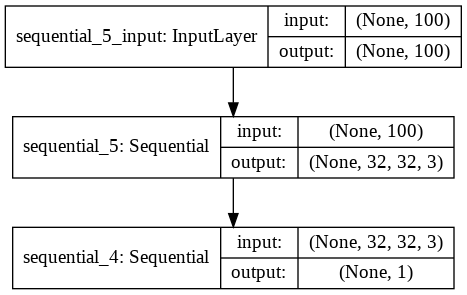

In [ ]:
plot_model(gan_model, show_shapes=True, show_layer_names=True)

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

In [ ]:
from numpy.random import randn

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=512):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = discriminator()
# create the generator
g_model = generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
>49, 52/97, d1=0.352, d2=0.437 g=2.545
>49, 53/97, d1=0.441, d2=0.276 g=2.432
>49, 54/97, d1=0.492, d2=0.350 g=2.175
>49, 55/97, d1=0.366, d2=0.425 g=2.167
>49, 56/97, d1=0.391, d2=0.415 g=2.152
>49, 57/97, d1=0.400, d2=0.317 g=2.018
>49, 58/97, d1=0.467, d2=0.447 g=2.022
>49, 59/97, d1=0.543, d2=0.431 g=2.048
>49, 60/97, d1=0.496, d2=0.426 g=2.060
>49, 61/97, d1=0.502, d2=0.433 g=1.996
>49, 62/97, d1=0.511, d2=0.432 g=2.094
>49, 63/97, d1=0.549, d2=0.393 g=2.158
>49, 64/97, d1=0.476, d2=0.382 g=2.197
>49, 65/97, d1=0.489, d2=0.415 g=2.237
>49, 66/97, d1=0.468, d2=0.392 g=2.249
>49, 67/97, d1=0.547, d2=0.363 g=2.094
>49, 68/97, d1=0.413, d2=0.472 g=2.242
>49, 69/97, d1=0.497, d2=0.354 g=2.248
>49, 70/97, d1=0.502, d2=0.333 g=2.108
>49, 71/97, d1=0.437, d2=0.396 g=2.134
>49, 72/97, d1=0.370, d2=0.402 g=2.333
>49, 73/97, d1=0.471, d2=0.380 g=2.183
>49, 74/97, d1=0.446, d2=0.386 g=2.072
>49, 75/97, d1=0.558, d2=0.513 g=2.067
>49, 76/97, d

In [ ]:
gan_model.save('GAN_MODEL.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


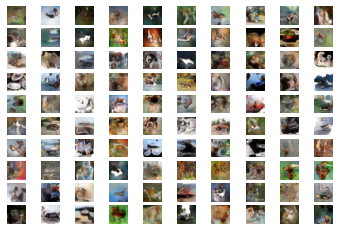

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()
 
# load model
model = load_model('generator_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)

In [ ]:
X.shape

(100, 32, 32, 3)

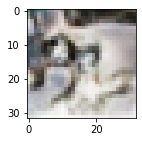

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(X[55])